In [1]:
import torch
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11,12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v1'
cfg1 = get_cfg(DATASET_DIR, version, 'SimpleBEV') # cvt_nuscenes_multiclass Sparse
device = torch.device('cuda:0') # cuda:5
model_version = '2024_0802_024954'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, _ = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='split', batch_size=4)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4
Dataset length: 49


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = True

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            loss = model.loss_func(pred,batch)
            vis_result = viz(batch,pred)
    # if i ==5:
    
            break   
model.metrics.update(pred,batch)


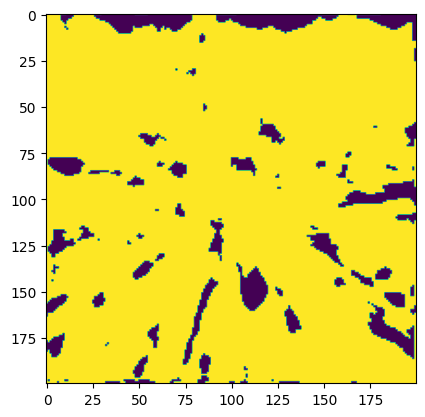

In [4]:
plt.imshow(((pred['VEHICLE'][0,0].sigmoid().detach().cpu())>0.4).numpy())

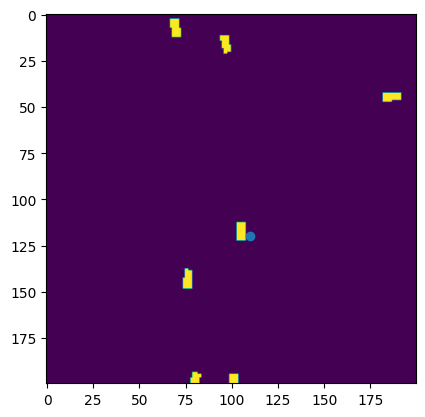

In [5]:
plt.imshow(batch['bev'][0,4].cpu().numpy())
plt.scatter([110],[120])

[[127.0992  220.08   ]
 [126.2496  171.76544]
 [126.3408  191.38784]
 [126.768   145.95392]]


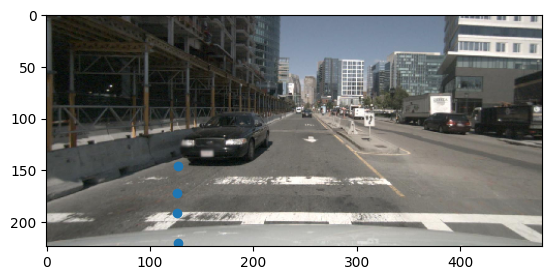

In [6]:
x = [[[ 2.6479e-01,  9.8250e-01]],

        [[ 2.6302e-01,  7.6681e-01]],

        [[ 2.6321e-01,  8.5441e-01]],

        [[ 2.6410e-01,  6.5158e-01]]]
x = np.array(x)[:,0]
x[:, 0] *= 480
x[:, 1] *= 224
print(x)
# x = x[2:6]
plt.imshow(batch['image'][0,4].cpu().permute(1,2,0))
plt.scatter(x[:,0],x[:,1])
plt.show()

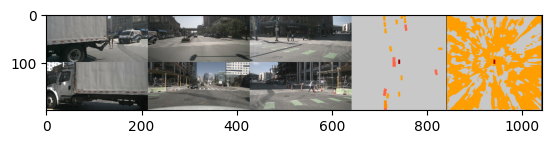

In [7]:
plt.imshow(vis_result[1])

In [8]:
for name, param in model.named_parameters():
    if param.requires_grad and param.grad is None:
        print(name)